# Picking an Ambulance

### Based on two criteria

- Closest ambulance - Based on shortest travel timeio
- Disruption - When I remove one ambulance, what is the resulting coverage and the difference? 

### Decision factor: 
- Severity of the case

In [4]:
import read_data
import numpy as np
from matplotlib import pyplot as plt
import copy
import time

# Data
(calls, allbases, demands, times, calls_latlong) = read_data.populate_data()
allbases = np.delete(np.array(allbases), 2, 1)
demands = np.delete(np.array(demands), 2, 1)
times = np.array(times)
calls_latlong = np.array(calls_latlong)

num_ambulances = 8

In [6]:
# Pasted from yesterday: choose bases using greedy
# Get the first base
times_copy = copy.deepcopy(times)

# Continually get the min cost row (most optimal base)
# Delete the columns that are covered by this base by r1
# Recalculate the total cost for each base
# Repeat

r1 = 600

numbases = 8
list_bases = []
total_covered = []
for x in range(numbases):
    print(np.shape(times_copy))
    covered = []
    row_num = 0
    for row in times_copy:
        count = 0
        for col in row:
            if col < r1:
                count += 1
        covered.append((row_num, count))
        row_num += 1
    
    d = [('index', int), ('covered', int)]
    covered = np.array(covered, d)
    
    min_cost = (np.sort(covered, order='covered', kind='mergesort')[-1])

    list_bases.append(min_cost[0])
    
    # Delete the columns (demands) that are covered by r1.
    
    primary_covered = [times_copy[min_cost[0]][i] < r1 for i in range(len(times_copy[min_cost[0]]))]
    covered_indices = [i for i in range(len(primary_covered)) if primary_covered[i] ]
    total_covered += covered_indices

    times_copy = np.delete(times_copy, covered_indices, axis=1)

ind = list_bases
print("Total Covered: " , len(total_covered))

(969, 100)
(969, 72)
(969, 54)
(969, 38)
(969, 26)
(969, 19)
(969, 15)
(969, 11)
Total Covered:  92


In [7]:
# ind = np.random.randint(0, allbases.shape[0], num_ambulances)
bases = allbases[ind,:]
points = np.delete(allbases, ind, 0)

chosen_base_costs = times[ind,:]

Need the travel time between the ambulance starting location and the case end location. 

- If ambulance is at base, and location can be using demand location, then do (base, location) --> (base, time)
- Else, query Google

In [8]:
# Randomly choose a demand point
call_location = np.random.randint(0, high=100)
call_location

33

In [9]:
# Fastest it can get there
current_travel_times = chosen_base_costs[:, call_location]
fastest = np.min(current_travel_times)
ambulance = -1

# Which ambulance to choose from chosen_base_costs? 
for amb in range(len(current_travel_times)):
    if fastest == current_travel_times[amb]:
        ambulance = amb
        break
ambulance, fastest, current_travel_times

(0, 578.0, array([ 578.,  805., 1271., 1288., 1543.,  995., 1173., 1124.]))

In [10]:
def ind_to_set_of_ind_one_removed(chosen_base_costs):
    """ Returns the set of all sets of bases with one ambulance removed. """
    
    all_one_removed = []
    for i in range(len(chosen_base_costs)):
        all_one_removed.append(np.delete(chosen_base_costs, i, axis=0))
    return all_one_removed

In [11]:
all_one_removed = ind_to_set_of_ind_one_removed(chosen_base_costs)

In [12]:
def radius_to_coverage (chosen_costs, r1=600, graph=True):
    r1_coverage = np.any(chosen_costs < r1, 0)
    r1_covered = np.nonzero(r1_coverage)
    r1_exposed = np.nonzero(np.logical_not(r1_coverage))

    c = np.shape(r1_covered)[1]
    e = np.shape(r1_exposed)[1]
    ratio = (c / (c + e))
    

    if graph:
        plt.figure()
        plt.scatter(demands[r1_covered,0],demands[r1_covered,1], c='b')
        plt.scatter(demands[r1_exposed,0],demands[r1_exposed,1], c='r')
        plt.scatter(demands[call_location,0], demands[call_location,1], c='green')
        plt.scatter(bases[:,0],bases[:,1], c='y')
        plt.show()
    
    return 100 * ratio

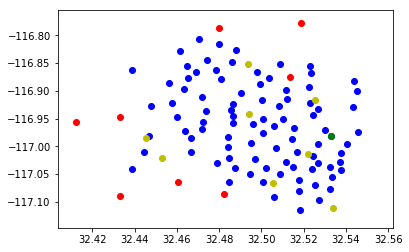

92.0

In [13]:
c = radius_to_coverage(chosen_base_costs)
c

In [14]:
facts = []
for amb in range(0, num_ambulances):
    coverage = radius_to_coverage(all_one_removed[amb], graph=False)
    print ("Amb #%2d:  "% amb, 
           "Travel time of  %2d min  %2d secs. " % (current_travel_times [amb] / 60, current_travel_times[amb] % 60) ,
           "Resulting coverage of  %2d%% " % coverage, 
           "and disruption of:  %2.f%%" % (c - coverage)
          )
    facts.append((amb, current_travel_times [amb], coverage, c-coverage, 
                 current_travel_times [amb]/ coverage))
d = [
        ('amb', int), 
        ('travel', int), 
        ('cover_result', float),
        ('disruption', float),
        ('composite', float)
    ]
print()

facts = np.array(facts, dtype=d)



Amb # 0:   Travel time of   9 min  38 secs.  Resulting coverage of  75%  and disruption of:  17%
Amb # 1:   Travel time of  13 min  25 secs.  Resulting coverage of  76%  and disruption of:  16%
Amb # 2:   Travel time of  21 min  11 secs.  Resulting coverage of  76%  and disruption of:  16%
Amb # 3:   Travel time of  21 min  28 secs.  Resulting coverage of  89%  and disruption of:   3%
Amb # 4:   Travel time of  25 min  43 secs.  Resulting coverage of  88%  and disruption of:   4%
Amb # 5:   Travel time of  16 min  35 secs.  Resulting coverage of  88%  and disruption of:   4%
Amb # 6:   Travel time of  19 min  33 secs.  Resulting coverage of  88%  and disruption of:   4%
Amb # 7:   Travel time of  18 min  44 secs.  Resulting coverage of  89%  and disruption of:   3%



### Making a decision

- Now there are `n` ambulances, ordered by the shortest travel time and the least disruption. 

- Depending on the severity of the case, decide whether the fastest time is necessary, or we can optimize for the set coverage.

- If there is a tie in one of the metrics, then choose the lowest of the two in the other metric.

In [15]:
def most_severe(ambs):
    return_list=[]
    acceptable_delta = 3
    
    fastest_amb = ambs[0]
    
    for amb in ambs:
        if amb['disruption'] - fastest_amb['disruption'] < acceptable_delta:
            return_list.append(amb['amb'])
        else:
            return return_list
    return return_list
        
    
def coverage_or_shortest(ambs, severity):
    """ Highest Severity is 5, Lowest is 1 """
#     if not ambs: 
#         print("Error: empty decision list.")
#         return
#     if severity > 5 or severity < 1: 
#         print("Error: invalid severity")
#         return
    
    if severity <= 5 or severity >= 3:
        print("Optimizing for travel time. ")
        ranked_ambulances = np.sort(ambs, order='travel')
        
        if severity == 5: return most_severe(ranked_ambulances)
#         elif severity == 4: 
            
        
    else:
        print("Optimizing for set coverage. ")
    
    

In [16]:
print("Sort by travel time.")
sort = np.sort(facts, order='travel')
for e in sort:
    print(e)
print("Shortest Travel: " , sort[0], "\n")

print("Sort by maximal coverage.")
sort = np.sort(facts, order='disruption')
sort
for e in sort:
    print(e)
print("Least disruption: ", sort[0], "\n")

severity = 5
print("Severity level %d" %severity)
chosen_ambulances = coverage_or_shortest(facts, severity)

chosen_ambulances

Sort by travel time.
(0, 578, 75., 17., 7.70666667)
(1, 805, 76., 16., 10.59210526)
(5, 995, 88., 4., 11.30681818)
(7, 1124, 89., 3., 12.62921348)
(6, 1173, 88., 4., 13.32954545)
(2, 1271, 76., 16., 16.72368421)
(3, 1288, 89., 3., 14.47191011)
(4, 1543, 88., 4., 17.53409091)
Shortest Travel:  (0, 578, 75., 17., 7.70666667) 

Sort by maximal coverage.
(3, 1288, 89., 3., 14.47191011)
(7, 1124, 89., 3., 12.62921348)
(4, 1543, 88., 4., 17.53409091)
(5, 995, 88., 4., 11.30681818)
(6, 1173, 88., 4., 13.32954545)
(1, 805, 76., 16., 10.59210526)
(2, 1271, 76., 16., 16.72368421)
(0, 578, 75., 17., 7.70666667)
Least disruption:  (3, 1288, 89., 3., 14.47191011) 

Severity level 5
Optimizing for travel time. 


[0, 1, 5, 7, 6, 2, 3, 4]

Original:


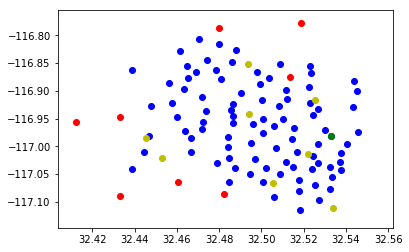

Fastest travel time


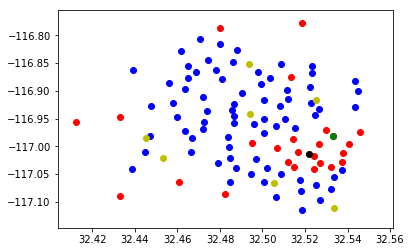

In [17]:
print ("Original:")
radius_to_coverage(chosen_base_costs)

top_amb = chosen_ambulances[0]


# print(np.shape(chosen_base_costs))
# print(chosen_base_costs)
new_coverage = copy.deepcopy(chosen_base_costs)
new_coverage = np.delete(new_coverage, top_amb, axis=0)



r1_coverage = np.any(new_coverage < r1, 0)

# print(r1_coverage)
r1_covered = np.nonzero(r1_coverage)
r1_exposed = np.nonzero(np.logical_not(r1_coverage))
plt.figure()
plt.scatter(demands[r1_covered,0],demands[r1_covered,1], c='b')
plt.scatter(demands[r1_exposed,0],demands[r1_exposed,1], c='r')
plt.scatter(bases[:,0],bases[:,1], c='y')

plt.scatter(bases[top_amb,0], bases[top_amb,1], c='black')
plt.scatter(demands[call_location,0], demands[call_location,1], c='green')




print ("Fastest travel time")
plt.show()

Original:


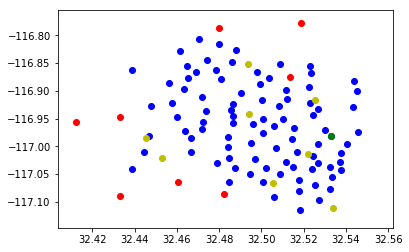

Least Coverage loss


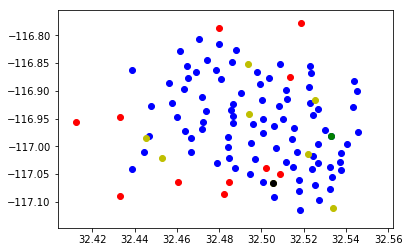

In [18]:
print ("Original:")
radius_to_coverage(chosen_base_costs)

top_amb = sort[0][0]

# print(np.shape(chosen_base_costs))
# print(chosen_base_costs)
new_coverage = copy.deepcopy(chosen_base_costs)
new_coverage = np.delete(new_coverage, top_amb, axis=0)



r1_coverage = np.any(new_coverage < r1, 0)

# print(r1_coverage)
r1_covered = np.nonzero(r1_coverage)
r1_exposed = np.nonzero(np.logical_not(r1_coverage))
plt.figure()
plt.scatter(demands[r1_covered,0],demands[r1_covered,1], c='b')
plt.scatter(demands[r1_exposed,0],demands[r1_exposed,1], c='r')
plt.scatter(bases[:,0],bases[:,1], c='y')

plt.scatter(bases[top_amb,0], bases[top_amb,1], c='black')
plt.scatter(demands[call_location,0], demands[call_location,1], c='green')

print("Least Coverage loss")

plt.show()


### Next step

- Severity -- static calculation?
- Moving an off duty ambulance to another location. Since this ambulance would technically be on duty, a granular calculation of set coverage?